In [ ]:
pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfull

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

In [ ]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                        torch.matmul(H, self.W_hz) + self.b_z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

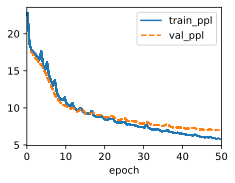

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [5]:
# Concise implementation
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

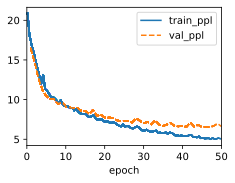

In [6]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [7]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the time traveller '